<a href="https://colab.research.google.com/github/davidfague/Neural-Modeling/blob/main/AA_Reduced_Order_L5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neuron

In [2]:
!git clone https://github.com/chenziao/Stylized-Cell-Inference.git
%cd Stylized-Cell-Inference/

fatal: destination path 'Stylized-Cell-Inference' already exists and is not an empty directory.
/content/Stylized-Cell-Inference


In [3]:
from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from typing import Optional, List, Tuple, Union

from cell_inference.config import params, paths
from cell_inference.cells.simulation import Simulation, Simulation_stochastic
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.currents.pointconductance import PointConductance
from cell_inference.utils.metrics.measure_passive_properties import measure_passive_properties
from cell_inference.utils.metrics.measure_segment_distance import measure_segment_distance
from cell_inference.utils.feature_extractors.SummaryStats2D import process_lfp
import cell_inference.utils.feature_extractors.SummaryStats2D as ss2
from cell_inference.utils.plotting.plot_morphology import plot_morphology
from cell_inference.utils.plotting.plot_variable_with_morphology import plot_variable_with_morphology
from cell_inference.utils.plotting.plot_results import plot_lfp_heatmap, plot_lfp_traces
from cell_inference.utils.transform.data_transform import log_modulus

h.load_file('stdrun.hoc')
source_directory = os.path.join('cell_inference', 'resources', 'compiled', 'mechanisms_reduced_order')
os.chdir(source_directory)
os.system(f"nrnivmodl > /dev/null 2>&1")
os.chdir("../../../../")
h.nrn_load_dll(paths.COMPILED_LIBRARY_REDUCED_ORDER)
geo_standard = pd.read_csv(paths.GEO_REDUCED_ORDER, index_col='id')
params.DT = 0.1 # comment for default
h.dt = params.DT
h.steps_per_ms = 1/h.dt

h.tstop = 2000.

### Setup smiulation parameters

In [4]:
# Biophysical parameters
filepath = './cell_inference/resources/biophys_parameters/ReducedOrderL5_stochastic.json' # active dendrites
# filepath = './cell_inference/resources/biophys_parameters/ReducedOrderL5.json' # higher gNa dendrites
with open(filepath) as f:
    biophys_param = json.load(f)

In [5]:
biophys = [2.04, 0.0213 * 0.6, 0.0213 * 0.6, 0.693 * 2, 0.000261 * 2, 100., 100., 0.0000525, 0.000555, 0.0187, # 2.04, 0.0639, 0.693 (1.0), 0.000261
          np.nan, np.nan, np.nan, np.nan, .6, 2.4]
# biophys = []
biophys_comm = {}

# interpret_params = False  # not using parameter interpreter
# geo_param = [135, 652, 163, 1.77, 1.26, .99] # 5 - 595 um
interpret_params = True  # using parameter interpreter
# geo_param = [1000, 1.]  # total length, radius scale
geo_param = [950., 0.142, 1., 0.59]  # total length 100-1200, prox prop 0.02-0.35, radius scale 0.4-1.5 (0.6-1.2), dist/prox radius 0.4-0.8 [950., 0.142, 1., 0.59]

loc_param = [0., 0., 0., 0., 1., 0.] # position (x,y,z,alpha,h,phi)

In [6]:
ncell = 0
biophys_rep = np.tile(biophys,(ncell, 1))
# biophys_rep[:,5] = np.linspace(200, 300, ncell)
biophys = np.vstack((biophys_rep, biophys))
print(biophys)

[[2.040e+00 1.278e-02 1.278e-02 1.386e+00 5.220e-04 1.000e+02 1.000e+02
  5.250e-05 5.550e-04 1.870e-02       nan       nan       nan       nan
  6.000e-01 2.400e+00]]


In [7]:
geo_param_rep = np.tile(geo_param,(ncell,1))
# geo_param_rep[:,6] = np.linspace(.1, .2, ncell)
# geo_param_rep[:,[2,3,4,6]] *= 1.0 # scale radius
geo_param = np.vstack((geo_param_rep, geo_param))
print(geo_param)

[[9.50e+02 1.42e-01 1.00e+00 5.90e-01]]


In [8]:
Len = {'p': 100 + 20, 'b': 100, 'a': 250}
# Len = {'p': 40 + 20, 'b': 160, 'a': 250}
# exc: apical / basal (#syn * PSC * FR * Prob / length)
print((7440 * 26 / Len['a']) / (4650 * 37 / Len['b']))
# inh: basal / apical
print((7440 * 0.72/ Len['a']) / (4650 * 0.3 / Len['b']))
# inh: sama / basal
print((256 * 162 * 17 * 0.88 / Len['p']) / (1023 * 24 * 4 * 0.72 / Len['b']))

0.44972972972972974
1.536
7.311827956989249


In [9]:
attr_kwargs = {}

point_conductance_division = {'soma': [0], 'perisomatic': [1,4], 'basal': [2,3], 'apical': [7,8,9,10]}
dens_params = { # ALL SET TO 0 TO REMOVE look on github for original values
    'soma': {'g_e0': 0., 'g_i0': 0., 'std_e': 0., 'std_i': 0.},
    'perisomatic': {'g_e0': 0., 'g_i0': 0., 'std_e': 0., 'std_i': 0.},
    'basal': {'g_e0': 0., 'g_i0': 0., 'std_e': 0., 'std_i': 0.},
    'apical': {'g_e0': 0., 'g_i0': 0., 'std_e': 0., 'std_i': 0.}
}
cnst_params = {'tau_e': 2., 'tau_i': 10., 'tau_n': 40.}
has_nmda = True
lornomal_gfluct = False#True

randseed = 0

In [10]:
biophys_param

{'passive': [{'ra': 100}],
 'conditions': [{'celsius': 34,
   'erev': [{'ena': 50.0, 'section': 'soma', 'ek': -85.0},
    {'ena': 50.0, 'section': 'dend', 'ek': -85.0},
    {'ena': 50.0, 'section': 'apic', 'ek': -85.0}],
   'v_init': -67.0}],
 'genome': [{'section': 'soma',
   'name': 'g_pas',
   'value': '0.0000338',
   'mechanism': ''},
  {'section': 'soma', 'name': 'e_pas', 'value': '-72.0', 'mechanism': ''},
  {'section': 'dend', 'name': 'g_pas', 'value': '0.0000467', 'mechanism': ''},
  {'section': 'dend', 'name': 'e_pas', 'value': '-72.0', 'mechanism': ''},
  {'section': 'apic', 'name': 'g_pas', 'value': '0.0000589', 'mechanism': ''},
  {'section': 'apic', 'name': 'e_pas', 'value': '-72.0', 'mechanism': ''},
  {'section': 'pas_dend',
   'name': 'g_pas',
   'value': '0.0000100',
   'mechanism': ''},
  {'section': 'pas_dend', 'name': 'e_pas', 'value': '-72.0', 'mechanism': ''},
  {'section': 'soma', 'name': 'cm', 'value': '1.0', 'mechanism': ''},
  {'section': 'soma', 'name': 'Ra',

In [11]:
def update_conductance(biophys, section, name, value):
    if 'genome' in biophys:
        for entry in biophys['genome']:
            if entry['section'] == section and entry['name'] == name:
                entry['value'] = value
                return

# Update sodium conductance in the soma
update_conductance(biophys_param, 'soma', 'gNaTa_tbar_NaTa_t', 0)
update_conductance(biophys_param, 'soma', 'gSKv3_1bar_SKv3_1', 0) # 0.3
update_conductance(biophys_param, 'soma', 'gSK_E2bar_SK_E2', 0)
update_conductance(biophys_param, 'soma', 'gNap_Et2bar_Nap_Et2', 0) #'gSK_E2bar_SK_E2'
update_conductance(biophys_param, 'soma', 'gK_Tstbar_K_Tst', 0)
update_conductance(biophys_param, 'soma', 'gK_Pstbar_K_Pst', 0)

In [12]:
# biophys_param # specify conductances

In [13]:
geo_standard # specify morphology

,name,type,pid,axial,L,R,ang
id,,,,,,,
0,soma,1,0,True,0.0,10.000000,0.000000
1,proxbasal,3,0,False,40.0,0.647857,-0.785398
2,midbasal,3,1,False,60.0,0.334880,-0.785398
3,distbasal,3,2,False,100.0,0.253900,-0.785398
4,proxtrunk,4,0,True,135.0,1.769400,1.570796
6,midtrunk,4,4,True,652.0,1.259480,1.570796
7,disttrunk,4,6,True,163.0,0.990100,1.570796
8,proxtuft,4,7,False,100.0,0.387700,1.047198
9,midtuft,4,8,False,100.0,0.302560,1.047198


In [14]:
#geo_param # not sure what these are

In [15]:
sim = Simulation_stochastic(
    cell_type = CellTypes.REDUCED_ORDER,
    ncell = ncell + 1,
    geometry = geo_standard,
    electrodes = params.ELECTRODE_POSITION,
    loc_param = loc_param,
    geo_param = geo_param,
    biophys = biophys,
    full_biophys = biophys_param,
    biophys_comm = biophys_comm,
    interpret_params = interpret_params,
    interpret_type = 3,
    min_distance = params.MIN_DISTANCE,
    spike_threshold = params.SPIKE_THRESHOLD,
    cell_kwargs = {'attr_kwargs': attr_kwargs},
    point_conductance_division=point_conductance_division,
    dens_params=dens_params,
    cnst_params=cnst_params,
    has_nmda=has_nmda,
    lornomal_gfluct=lornomal_gfluct,
    tstart=200.,
    randseed = randseed
)

cell = sim.cells[-1]
print(sim.geo_param)

[[134.9        652.08       163.02         1.7694       1.35910193
    1.043946  ]]


#### Record membrane potential

In [16]:
V_rec = Recorder(cell.segments)

#### Simulation results

In [17]:
sim.run_neuron_sim()

Vm = V_rec.as_numpy()

In [18]:
# print('Spike count: %d' % (nspk))
# if nspk == 0:
#     print(f"No spikes.")#raise ValueError('No spike.')
# print('Firing rate: %.2f' % (firing_rate))

#### Membrane voltage

In [19]:
# %matplotlib inline

# plot_sec_type = [0, 3, 6, 7, 8, 10] # section type for plot membrane potential
# loc = .5

# n_type = len(plot_sec_type)
# t = sim.t()
# plt.figure(figsize=(8, 3 * n_type))
# for i, type_id in enumerate(plot_sec_type):
#     plt.subplot(n_type, 1, i + 1)
#     for isec in cell.sec_id_lookup[type_id]:
#         iseg = cell.sec_id_in_seg[isec] + int(loc * cell.all[isec].nseg)
#         plt.plot(t, Vm[iseg, :])
#     plt.ylabel('Vm (mV)')
#     plt.title(cell.geometry.loc[type_id, 'name'])
# plt.xlabel('time (ms)')
# plt.tight_layout()
# plt.show()

#### Calculate passive properties

In [20]:
#dir(cell.all[0])

In [21]:
import csv

# Assume cell.all is a list of sections
results = []

for sec in cell.all:
    sec_name = str(sec).split('.')[-1]

    Rm = 1/sec.g_pas
    Cm = sec.cm
    Ra = sec.Ra
    time_constant = Rm * Cm / 10000

    result = {
            'section_name': sec_name,
            'L (um)': round(sec.L, 3),
            'diam3d (um)': sec.diam3d(0),
            'Rm (MOhm)': round(Rm / 10000, 3),
            'Cm (uf/cm2)': round(Cm, 3),
            'Ra (ohm cm)': round(Ra, 3),
            'time_constant (RC)': round(time_constant, 3),
            'nseg': sec.nseg,
            'psection': sec.psection(),

            'name': sec.name()
    }
    results.append(result)

    #print(f"{sec_name}: Rm: {result['Rm_MOhm']} MOhm, Cm: {result['Cm']} µF, Ra: {result['Ra']} Ohm, Tau: {result['time_constant']} ms")

# Create the directory if it doesn't exist
!if [ ! -d "AA_output" ]; then mkdir "AA_output"; fi

# Save results to CSV
with open('AA_output/section_properties.csv', 'w', newline='') as csvfile:
    fieldnames = results[0].keys()#['section_name', 'Rm_MOhm', 'Cm', 'Ra', 'time_constant', 'diam3d', 'name, ']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for result in results:
        writer.writerow(result)

print("Results have been saved to AA_output/section_properties.csv.")

Results have been saved to AA_output/section_properties.csv.


In [22]:
for i in range(ncell):
    Vrest, Rin, Tau = measure_passive_properties(Vm[i],t,sim.cells[i].injection[0].pp_obj)
    print(Vrest, Rin, Tau)

# (-67.28648876896166, 102.19853962576195, 15.849999999985585)  # [950., 0.142, 1., 0.59] geo_param
# (-67.94989081468924, 122.86662601811145, 15.724999999985698)  # [950., 0.142, 0.7, 0.8]
# (-66.68920003388767, 66.73068344994846, 18.599999999983083)  # [1200., 0.35, 1.5, 0.8]
# (-68.18723921905612, 171.26541594565055, 14.574999999986744)  # [100., 0.02, 0.4, 0.4]

#### Get segment coordinates for given cell and calculate electrotonic distance

In [23]:
soma = cell.soma
section_list = cell.all
sec_type_swc = {sec['name']: sec['type'] for _, sec in geo_standard.iterrows()}
sec_type = [sec_type_swc[sec.name().split('.')[-1]] for sec in section_list]
freq = 0 # Hz

seg_prop, Rin, Rin_pha = measure_segment_distance(soma, section_list, sec_type, freq)
print(Rin, Rin_pha) # Megohms, rad

107.13678730215862 0.0


In [24]:
%matplotlib inline

seg_coords = cell.seg_coords
t = sim.t()
# t_idx = slice(sim.tstart, None)
t_idx = slice(None)
#im = sim.lfp[-1].calc_im()[:, t_idx]
# im_den = im / np.expand_dims(seg_prop['seg_area'], 1) # nA/um^2
#im_den = im / np.diff(seg_prop['distance'], axis=1) # nA/um

select_seg = None
# select_seg = seg_prop['swc_type'] != 1 # excluding soma

#var = im_den
varname = 'Transmembrane current density per unit length (nA/um)'
axes = ['x', 'y']
n_dist = 20
max_per_dist = 1
space = 1.
normalized_space = True
sort_by_dist = True
figsize = (12, 9)
fontsize = 15
scalebar_size = 50

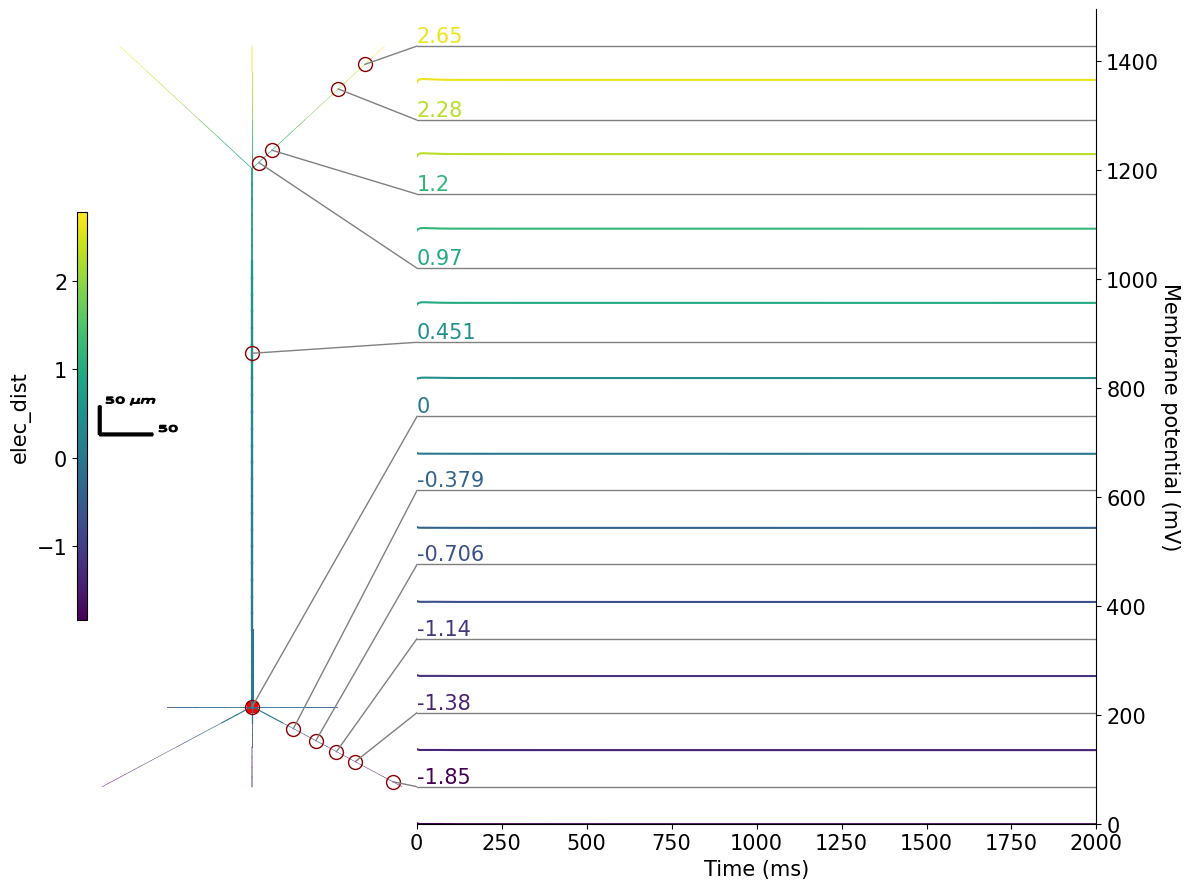

In [25]:
select_seg = None
# select_seg = seg_prop['swc_type'] != 1 # excluding soma

var = Vm[:, t_idx]
varname = 'Membrane potential (mV)'
n_dist = 12
space = 2.
normalized_space = True
sort_by_dist = True

_ = plot_variable_with_morphology(seg_coords, seg_prop, var, t=t[t_idx], axes=axes,
                                  distance_type='elec_dist', n_dist=n_dist,
                                  select_seg=select_seg, max_per_dist=max_per_dist, varname=varname,
                                  space=space, normalized_space=normalized_space, sort_by_dist=sort_by_dist,
                                  figsize=figsize, fontsize=fontsize, scalebar_size=scalebar_size)

In [26]:
# sim.run_neuron_sim()
# Vm = V_rec.as_numpy()
# plt.plot(Vm[0,:])

In [27]:
spike_train = [1000]
vec = h.Vector(spike_train)
stim = h.VecStim()
stim.play(vec)
synapse = h.AlphaSynapse1(cell.soma(0.5))
netcon_for_dvsoma_dvdend = h.NetCon(stim, synapse, 1, 0, 1)

In [28]:
# sim.run_neuron_sim()
# Vm = V_rec.as_numpy()
# plt.plot(Vm[0,:])

distance: [810.56495158 837.73495483 864.90495809 892.07496134 919.2449646
 946.41496785]
ratio: [0.1660629  0.15226028 0.14038131 0.13014524 0.121252   0.11342765]
distance: [159.7199929  189.3599909  218.9999889  248.63998691 278.27998491
 307.91998291 337.55998091 367.19997892 396.83997692 426.47997492
 456.11997292 485.75997093 515.39996893 545.03996693 574.67996493
 604.31996294 633.95996094 663.59995894 693.23995694 722.87995494
 752.51995295 782.15995095]
ratio: [0.74705764 0.66553258 0.59601607 0.53857013 0.49104081 0.45136753
 0.41791287 0.38936148 0.36444469 0.34266501 0.32339284 0.30602958
 0.29010822 0.27540091 0.26163544 0.24851184 0.23585254 0.22363377
 0.21179483 0.20033958 0.18931648 0.17868828]
distance: [ 23.48999939  50.46999817  77.44999695 104.42999573 131.40999451]
ratio: [0.98357607 0.94733387 0.90668204 0.86218185 0.81502689]


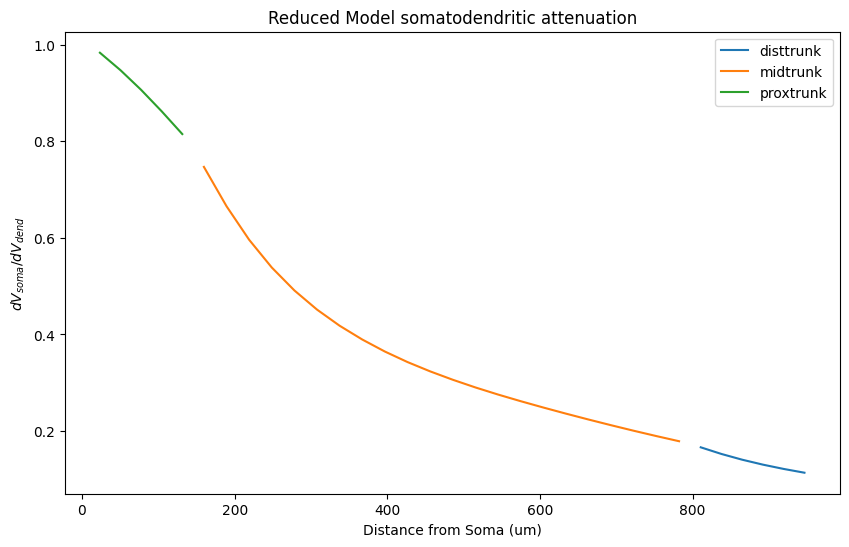

True

In [29]:
def get_sec_type(segment):
    # Placeholder function - replace with actual method to get section type
    return str(segment.sec).split('>.')[-1]
# Initialize lists to store data
distances = []
dvsoma_by_dv_dends = []
section_types = []

for i, seg in enumerate(cell.segments):
    sec_type = get_sec_type(seg)
    if 'trunk' in sec_type:
      synapse.loc(seg)
      dist = h.distance(synapse.get_segment(), cell.soma(0.5))
      sim.run_neuron_sim()
      Vm = V_rec.as_numpy()
      #plt.plot(Vm[0,:])

      original_dend_vm = Vm[i, 9950]
      original_soma_vm = Vm[0, 9950]
      dend_vm_max = max(Vm[i, 9500:])
      soma_vm_max = max(Vm[0, 9500:])

      soma_diff = soma_vm_max - original_soma_vm
      dend_diff = dend_vm_max - original_dend_vm
      dvsoma_by_dv_dend = soma_diff / dend_diff

      distances.append(dist)
      dvsoma_by_dv_dends.append(dvsoma_by_dv_dend)
      section_types.append(sec_type)
      #print(dvsoma_by_dv_dend, dist)

# Combine lists into a structured array for easy sorting
data = np.rec.array([
    (dist, ratio, sec_type) for dist, ratio, sec_type in zip(distances, dvsoma_by_dv_dends, section_types)],
    dtype=[('distance', 'f8'), ('ratio', 'f8'), ('section_type', 'U10')]
)

# Sort data by section type and then by distance within each section type
sorted_data = np.sort(data, order=['section_type', 'distance'])

# Now, you can plot your data. Here's a basic way to do it:
plt.figure(figsize=(10, 6))
for sec_type in np.unique(sorted_data['section_type']):
    # Filter data for the current section type
    sec_data = sorted_data[sorted_data['section_type'] == sec_type]
    plt.plot(sec_data['distance'], sec_data['ratio'], label=sec_type)
    print(f"distance: {sec_data['distance']}")
    print(f"ratio: {sec_data['ratio']}")

plt.xlabel('Distance from Soma (um)')
plt.ylabel('$dV_{soma} / dV_{dend}$')
plt.title('Reduced Model somatodendritic attenuation')
plt.legend()
plt.show()

netcon_for_dvsoma_dvdend.active(False) # turn off synapse for other simulations

In [30]:
# sec_data['ratio']

In [31]:
cell.add_injection(sec_index=0, amp = -1.0, dur = 2000, delay= 1000)
sim.run_neuron_sim()
Vm = V_rec.as_numpy()

-68.72542443031675 -112.80617530956144
time_constant_Vm: -98.70033502820314
time_constant_time: 1004.5
soma input resistance: 44.08075087924469
time constant: 4.5 ms


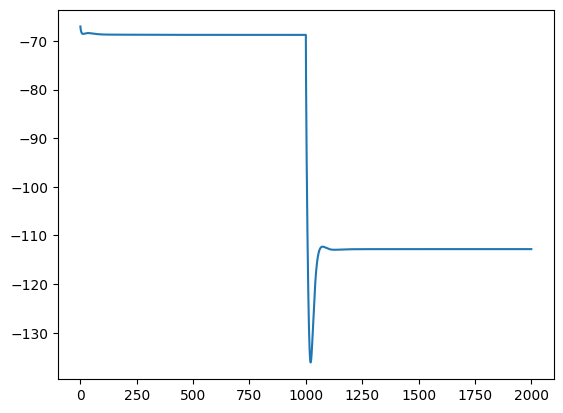

In [32]:
cell.injection[0].pp_obj.amp = -1.0

plt.plot(t, Vm[0, :])
Vm__soma_initial_SS = Vm[0, 5000]
Vm_soma_final_SS = Vm[0, 15000]
print(Vm[0, 5000], Vm[0, 15000])

# calculate input resistance
soma_input_resistance = (Vm_soma_final_SS - Vm__soma_initial_SS) / -1 # mV/nA =
time_constant_Vm = Vm__soma_initial_SS + (Vm_soma_final_SS - Vm__soma_initial_SS) * .68
print(f"time_constant_Vm: {time_constant_Vm}")

# calculate nearest voltage index to the voltage where time_constant occurs
abs_diffs = np.abs(Vm[0] - time_constant_Vm)
index_nearest = np.argmin(abs_diffs)

time_constant_chosen_Vm = Vm[0, index_nearest]
time_constant = (index_nearest-10000) / 10


print(f"time_constant_time: {index_nearest/10}")
print(f"soma input resistance: {soma_input_resistance}")
print(f"time constant: {time_constant} ms")

In [33]:
print(len(Vm[0]))

20001


In [34]:
print(Vm[0, 5000], Vm[0, 15000])

-68.72542443031675 -112.80617530956144


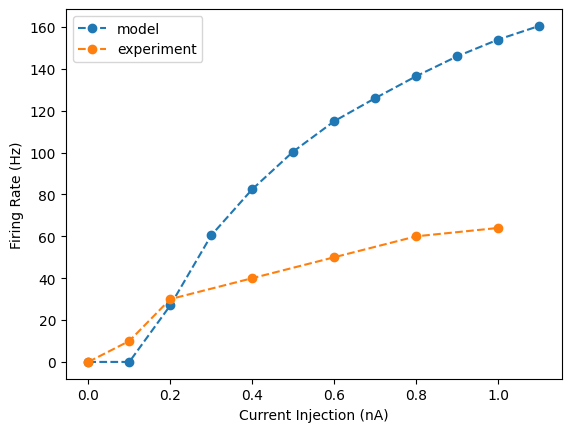

In [35]:
exp_firing_rates = [0,10,30,40,50,60,64]
exp_amplitudes = [0,0.1,0.2,0.4,0.6,0.8,1.0]

total_amp = 0
firing_rates = [0]
amplitudes = [0]

cell.injection[0].pp_obj.delay=0
while total_amp <= 1.0:
  total_amp +=0.1
  cell.injection[0].pp_obj.amp = total_amp
  sim.run_neuron_sim()
  Vm = V_rec.as_numpy()
  # plt.plot(Vm[0,:])



  spk_window = [-2., 4.] # ms
  spk_windows, nspk = sim.get_spk_windows(-1, spk_window=spk_window)
  firing_rate = nspk/2#1000. * nspk / (h.tstop - sim.tstart * h.dt)
  firing_rates.append(firing_rate)
  amplitudes.append(total_amp)

plt.figure()
plt.plot(amplitudes, firing_rates, label='model', linestyle='dashed', marker='o')
plt.plot(exp_amplitudes, exp_firing_rates, label ='experiment', linestyle='dashed', marker='o')
plt.ylabel('Firing Rate (Hz)')
plt.xlabel('Current Injection (nA)')
plt.legend()
cell.injection[0].pp_obj.amp=0

In [36]:
print(f"amplitudes: {amplitudes}")
print(f"firing_rates: {firing_rates}")
print()
print(f"exp_amplitudes: {exp_amplitudes}")
print(f"exp_firing_rates: {exp_firing_rates}")

amplitudes: [0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999, 0.9999999999999999, 1.0999999999999999]
firing_rates: [0, 0.0, 27.0, 60.5, 82.5, 100.5, 115.0, 126.0, 136.5, 146.0, 154.0, 160.5]

exp_amplitudes: [0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
exp_firing_rates: [0, 10, 30, 40, 50, 60, 64]


In [37]:
# spk_window = [-2., 4.] # ms
# spk_windows, nspk = sim.get_spk_windows(-1, spk_window=spk_window)

# iseg = np.array([cell.sec_id_in_seg[isec] + int(loc * cell.all[isec].nseg) for isec in cell.sec_id_lookup[plot_sec_type[0]]])
# Vm_avg = np.mean([Vm[iseg, win[0]:win[1]] for win in spk_windows], axis=(0, 1))

# plt.figure(figsize=(8, 3))
# plt.plot(t[:Vm_avg.size], Vm_avg)
# plt.ylabel('Vm (mV)')
# plt.title('Averaged action potential')
# plt.xlabel('time (ms)')
# plt.show()

In [38]:
# %matplotlib inline

# plot_sec_type = [0, 3, 6, 7, 8, 10] # section type for plot membrane potential
# loc = .5

# n_type = len(plot_sec_type)
# t = sim.t()
# plt.figure(figsize=(8, 3 * n_type))
# for i, type_id in enumerate(plot_sec_type):
#     plt.subplot(n_type, 1, i + 1)
#     for isec in cell.sec_id_lookup[type_id]:
#         iseg = cell.sec_id_in_seg[isec] + int(loc * cell.all[isec].nseg)
#         plt.plot(t, Vm[iseg, :])
#     plt.ylabel('Vm (mV)')
#     plt.title(cell.geometry.loc[type_id, 'name'])
# plt.xlabel('time (ms)')
# plt.tight_layout()
# plt.show()

In [39]:
# dir(h)

In [40]:
neuron_r = h.Random()
neuron_r.MCellRan4(1111111)

1111111.0

In [41]:
spike_train = [1000]
vec = h.Vector(spike_train)
stim = h.VecStim()
stim.play(vec)
synapses = []
netcons = []
for i in range(200):
  synapse = h.pyr2pyr(cell.all[15](0.5))
  neuron_r.uniform(0, 1)
  synapse.setRandObjRef(neuron_r)
  synapse.P_0=1
  synapses.append(synapse)
  netcon = h.NetCon(stim, synapse, 1, 0, 1)
  netcons.append(netcon)
  netcon.active(False)

In [42]:
cell.segments.index(cell.all[15](0.5))

63

In [43]:
# neuron_r = h.Random()
# neuron_r.MCellRan4(1111111)
# neuron_r.uniform(0, 1)
# synapse.setRandObjRef(neuron_r)

In [44]:
netcons[0].weight[0]=0.1

In [45]:
print(netcons[0].weight[0])

0.1


t_downsampled_rounded: [1000.  1000.3 1000.6 1000.9 1001.2 1001.5 1001.8 1002.1 1002.4 1002.7
 1003.  1003.3 1003.6 1003.9 1004.2 1004.5 1004.8 1005.1 1005.4 1005.7
 1006.  1006.3 1006.6 1006.9 1007.2 1007.5 1007.8 1008.1 1008.4 1008.7
 1009.  1009.3 1009.6 1009.9 1010.2 1010.5 1010.8 1011.1 1011.4 1011.7
 1012.  1012.3 1012.6 1012.9 1013.2 1013.5 1013.8 1014.1 1014.4 1014.7
 1015.  1015.3 1015.6 1015.9 1016.2 1016.5 1016.8 1017.1 1017.4 1017.7
 1018.  1018.3 1018.6 1018.9 1019.2 1019.5 1019.8 1020.1 1020.4 1020.7
 1021.  1021.3 1021.6 1021.9 1022.2 1022.5 1022.8 1023.1 1023.4 1023.7
 1024.  1024.3 1024.6 1024.9 1025.2 1025.5 1025.8 1026.1 1026.4 1026.7
 1027.  1027.3 1027.6 1027.9 1028.2 1028.5 1028.8 1029.1 1029.4 1029.7
 1030.  1030.3 1030.6 1030.9 1031.2 1031.5 1031.8 1032.1 1032.4 1032.7
 1033.  1033.3 1033.6 1033.9 1034.2 1034.5 1034.8 1035.1 1035.4 1035.7
 1036.  1036.3 1036.6 1036.9 1037.2 1037.5 1037.8 1038.1 1038.4 1038.7
 1039.  1039.3 1039.6 1039.9 1040.2 1040.5 1040.8 1041

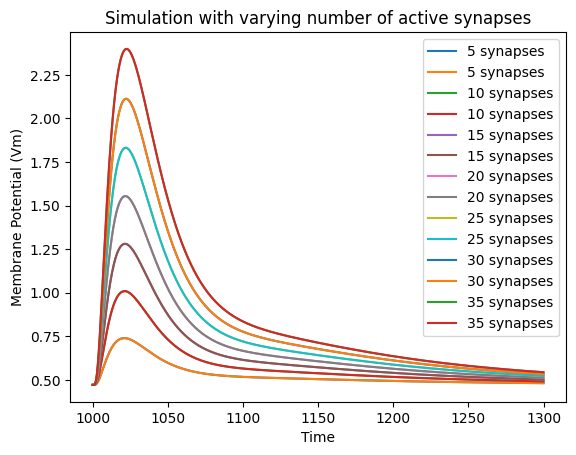

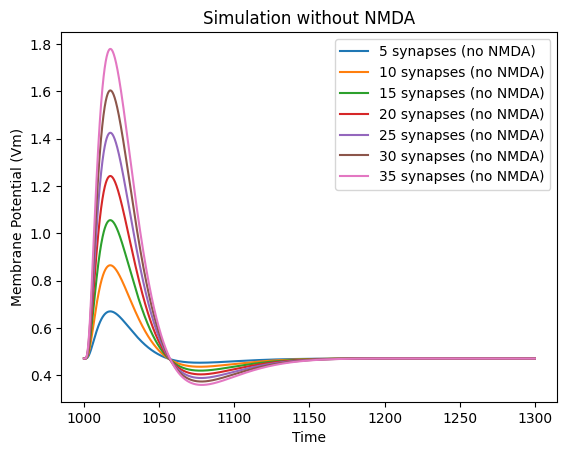

In [46]:
import matplotlib.pyplot as plt

num_syns_list = [5, 10, 15, 20, 25, 30, 35]

# Function to run the simulation
def run_simulation(num_active_syns, set_gbar_nmda_to_zero=False):
    global t  # Use the global 't' if it's defined outside this function
    global t_downsampled_rounded
    global t_slice
    for syn_index in range(num_active_syns):
        netcons[syn_index].active(True)
        netcons[syn_index].weight[0]=1
        if set_gbar_nmda_to_zero:
            synapses[syn_index].gbar_nmda = 0 # gnmdamax = 0
            synapses[syn_index].initW = 0.15
            synapses[syn_index].gbar_ampa = 0.5e-3
        else:
            synapses[syn_index].gbar_nmda = 1.5e-3# gnmdamax = 1000
            synapses[syn_index].gbar_ampa = 0.5e-3
            synapses[syn_index].initW = 0.15
    sim.run_neuron_sim()
    Vm = V_rec.as_numpy()
    # print(len(Vm))
    peak_Vm = np.max(Vm[0, 10000:14000])  # Record the peak Vm
    #dend_peak_Vm = np.max(Vm[63, 10000:14000])
    Vm_slice = Vm[0, 10000:13000]+69.2
    #Vm_downsampled = Vm_slice[::3]
    #Vm_downsampled_rounded = np.round(Vm_downsampled, 2)
    #print(f"Vm_downsampled_rounded: {Vm_downsampled_rounded}")
    # print(len(Vm_slice))
    plt.plot(t_slice, Vm_slice, label=f"{num_active_syns} synapses" + (" (no NMDA)" if set_gbar_nmda_to_zero else ""))
    data_to_save = np.column_stack((t_slice, Vm_slice))
    np.savetxt(f'AA_output/{num_active_syns} synapses' + (" (no NMDA)" if set_gbar_nmda_to_zero else "") + '.txt', data_to_save, delimiter='\t', header='Time\tVm', comments='')

    for syn_index in range(num_active_syns):  # Deactivate synapses after each run
        netcons[syn_index].active(False)
    return peak_Vm

# data_to_save = np.column_stack((t_downsampled_rounded, Vm_downsampled_rounded))

# Save the data to a text file, with time and Vm values separated by a tab
# np.savetxt('/mnt/data/Vm_and_time_data.txt', data_to_save, delimiter='\t', header='Time\tVm', comments='')


# Set up arrays to store data
peak_epsp_with_nmda = []
peak_epsp_no_nmda = []
peak_expected = []

t_slice = t[10000:13000]
t_downsampled = t_slice[::3]
t_downsampled_rounded = np.round(t_downsampled, 2)
print(f"t_downsampled_rounded: {t_downsampled_rounded}")
# print(f"time: {t[10000:14000]}")

# Run simulations with increasing number of synapses
for num_syns in num_syns_list:
    peak_soma = run_simulation(num_syns)
    peak_epsp_with_nmda.append(run_simulation(num_syns))

plt.title("Simulation with varying number of active synapses")
plt.xlabel("Time")
plt.ylabel("Membrane Potential (Vm)")
plt.legend()
#plt.xlim(1000,1400)
plt.show()

# Repeat the simulation with NMDA turned off
plt.figure()  # Start a new figure for the second set of simulations
for num_syns in num_syns_list:
    peak = run_simulation(num_syns, set_gbar_nmda_to_zero=True)
    peak_epsp_no_nmda.append(peak)

plt.title("Simulation without NMDA")
plt.xlabel("Time")
plt.ylabel("Membrane Potential (Vm)")
plt.legend()
#plt.xlim(1000,1400)
plt.show()

# # Now plot the peak EPSP values against the input number
# plt.figure()
# plt.plot(num_syns_list, peak_epsp_with_nmda, 'r-', label="AMPA & NMDA")
# plt.plot(num_syns_list, peak_epsp_no_nmda, 'gray', label="NMDA blocked")
# plt.xlabel("Input #")
# plt.ylabel("EPSP amplitude (mV)")
# plt.legend()
# plt.show()

In [47]:
%ls

 AA_output/                                  'Detailed vs Stylized LFP.ipynb'
 active_cell_find_gmax.ipynb                  environment.yml
 active_cell_passive_properties.ipynb         in_vivo_classification.ipynb
 active_cell_sim_lfp_membrane_voltage.ipynb   in_vivo_prediction.ipynb
 active_cell_sim_preprocess.ipynb             in_vivo_random_forest.ipynb
'Basal Dendrite Membrane Voltage.ipynb'       leak_equivalence_of_synapse.ipynb
 batch_ml_model.sh                            main.py
 batch_run_multi_simulation_pred.sh           notebook_examples/
 batch_run_multi_simulation.sh                parameter_feature_relation.ipynb
 batch_run_simulation.sh                      random_forest_feature_importance.ipynb
 bmtool/                                      README.md
 cell_inference/                              Reduced_Order_L5_properties.ipynb
 CODE_OF_CONDUCT.md                           Reduced_Order_L5_stochastic.ipynb
 data_in_vivo.ipynb                           requirements.tx

In [48]:
print(f"num_syns_list: {num_syns_list}")


print(f"peak_epsp_with_nmda: {peak_epsp_with_nmda}")
print(f"peak_epsp_with_no_nmda: {peak_epsp_no_nmda}")

num_syns_list: [5, 10, 15, 20, 25, 30, 35]
peak_epsp_with_nmda: [-68.4608826126136, -68.191077947769, -67.91945835889666, -67.64540551159232, -67.36821195817497, -67.08699918814618, -66.80073470403448]
peak_epsp_with_no_nmda: [-68.53003375985477, -68.33503393122538, -68.14425296905628, -67.95753778105872, -67.77473148732238, -67.59566454386112, -67.42017503063553]


baseline voltage: -68.72939184281431


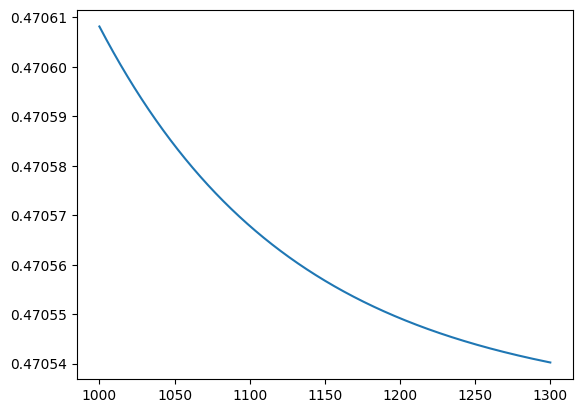

In [49]:
peak_no_syns = run_simulation(0)
print(f"baseline voltage: {peak_no_syns}")

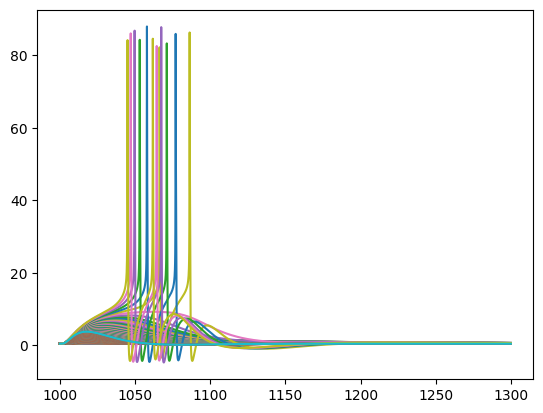

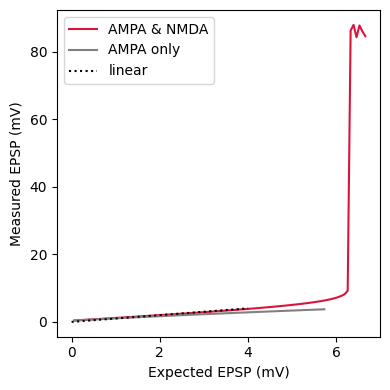

In [50]:
# Arrays to store data
peaks_control = []
peaks_ampa = []

# Run simulations
for num_syns in range(0, 100):
    peak_control = run_simulation(num_syns)
    peak_ampa = run_simulation(num_syns, set_gbar_nmda_to_zero=True)
    peaks_control.append(peak_control + 69.14)  # adjust based on baseline
    peaks_ampa.append(peak_ampa + 69.14)

# Calculate the expected EPSP values
unitary_control = peaks_control[29]/30
expected_control = np.linspace(1, 100, 100) * unitary_control
unitary_ampa = peaks_ampa[19]/20
expected_ampa = np.linspace(1, 100, 100) * unitary_ampa

# Plotting the results
plt.figure(figsize=[4, 4])
plt.plot(expected_control, peaks_control, 'crimson', label='AMPA & NMDA')
plt.plot(expected_ampa, peaks_ampa, 'gray', label='AMPA only')
plt.plot(range(5), range(5), 'k:', label='linear')  # assuming the expected is up to 20
plt.legend()
plt.xlabel('Expected EPSP (mV)')
plt.ylabel('Measured EPSP (mV)')
plt.tight_layout()
plt.show()

In [51]:
print(f"expected_control: {expected_control}")
print(f"peaks_control: {peaks_control}")
print(f"expected_ampa: {expected_ampa}")
print(f"peaks_ampa: {peaks_ampa}")

data_to_save = np.column_stack((expected_control, peaks_control, expected_ampa,peaks_ampa))
np.savetxt(f'AA_output/trunk_EPSPs' + '.txt', data_to_save, delimiter='\t', header='expected_control\tpeaks_control\texpected_ampa\tpeaks_ampa', comments='')

expected_control: [0.06654625 0.1330925  0.19963875 0.26618501 0.33273126 0.39927751
 0.46582376 0.53237001 0.59891626 0.66546251 0.73200877 0.79855502
 0.86510127 0.93164752 0.99819377 1.06474002 1.13128628 1.19783253
 1.26437878 1.33092503 1.39747128 1.46401753 1.53056378 1.59711004
 1.66365629 1.73020254 1.79674879 1.86329504 1.92984129 1.99638754
 2.0629338  2.12948005 2.1960263  2.26257255 2.3291188  2.39566505
 2.4622113  2.52875756 2.59530381 2.66185006 2.72839631 2.79494256
 2.86148881 2.92803507 2.99458132 3.06112757 3.12767382 3.19422007
 3.26076632 3.32731257 3.39385883 3.46040508 3.52695133 3.59349758
 3.66004383 3.72659008 3.79313633 3.85968259 3.92622884 3.99277509
 4.05932134 4.12586759 4.19241384 4.25896009 4.32550635 4.3920526
 4.45859885 4.5251451  4.59169135 4.6582376  4.72478385 4.79133011
 4.85787636 4.92442261 4.99096886 5.05751511 5.12406136 5.19060762
 5.25715387 5.32370012 5.39024637 5.45679262 5.52333887 5.58988512
 5.65643138 5.72297763 5.78952388 5.85607013 

In [52]:
# cell.all[15]

In [53]:
# sim.run_neuron_sim()
# Vm = V_rec.as_numpy()
# plt.plot(t,Vm[0,:])

In [54]:
!git clone https://github.com/cyneuro/bmtool.git

fatal: destination path 'bmtool' already exists and is not an empty directory.


In [55]:
from bmtool.bmtool.singlecell import Passive

Calculate passive properties

In [56]:
# Cell = lambda: sim.CreateCell(0)

In [57]:
# passive_obj = Passive(Cell, method='exp2')

In [58]:
# passive_obj.execute() #Reduced: 20.87 (ms); 75 (MOhms)} Detailed: 31 (MOhms); 25 (ms)